In [39]:
from PIL import Image
import clip
import os
import chromadb
import json
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
# model, tokenizer, img_processor = clip.load("mlx_model")
# inputs = {
#     "input_ids": tokenizer(["a photo of a cat", "a photo of a dog"]),
#     "pixel_values": img_processor(
#         [Image.open("assets/cat.jpeg"), Image.open("assets/dog.jpeg")]
#     ),
# }
# output = model(**inputs)

# # Get text and image embeddings:
# text_embeds = output.text_embeds
# image_embeds = output.image_embeds


In [41]:
client = chromadb.PersistentClient(path="database")
collection = client.get_or_create_collection(name="test", metadata={"hnsw:space": "cosine"})
model, tokenizer, img_processor = clip.load("mlx_model")

In [42]:
def get_embeddings(image, text):
    try:
        inputs = {
            "input_ids": tokenizer([text]),
            "pixel_values": img_processor([image]),
        }
        output = model(**inputs)
        return output.text_embeds, output.image_embeds
    except Exception as e:
        print(f"Error in get_embeddings: {str(e)}")
        print(f"Image type: {type(image)}")
        print(f"Text: {text}")
        return None, None

In [43]:
# # read json file
# with open('../data/final_labels_good_light.json', 'r') as f:
#     list_data = json.load(f)
# # {"img_08000.jpg": "aligned", "img_08001.jpg": "aligned", "img_08002.jpg": "aligned"}

In [44]:

# # {"img_08000.jpg": "aligned", "img_08001.jpg": "aligned", "img_08002.jpg": "aligned"}
# # get all keys
# keys = list(list_data.keys())
# for idx in tqdm(range(len(keys))):
#     # data path is ../data/images/ + keys[idx]
#     image_path = os.path.join('../data/train_set/good_light', keys[idx])
#     # print(image_path)
#     # read image
#     image = Image.open(image_path)
#     # print(image)
#     text = ["These steels are " + list_data[keys[idx]] + " with the stopper."]
#     # print(text)
#     text_embeds, image_embeds = get_embeddings(image, text[0])

#     # print(image_embeds)
#     # dict_data = {
#     #     "id": keys[idx].split('.')[0].split('_')[-1],  # Extract the numeric part after splitting by '.' and '_'
#     #     "document": text,
#     #     "embeddings": image_embeds,
#     #     "metadata": {"label": list_data[keys[idx]]}
#     # }
#     # print(dict_data)
#     collection.add(
#         ids=keys[idx].split('.')[0].split('_')[-1],
#         documents=text,
#         embeddings=image_embeds,
#         metadatas={"label": list_data[keys[idx]]}
#     )



In [45]:
collection.count()

5217

In [46]:
# get all embeddings to a np structure
# embeddings = collection.get(include=["embeddings"])["embeddings"]
# embeddings.shape

# randomly choose 1000 embeddings with label = aligned
aligned_embeddings = collection.get(include=["embeddings", "metadatas"], where={"label": "aligned"}, limit=1000)
aligned_embeddings = aligned_embeddings["embeddings"]
# randomly choose 1000 embeddings with label = not_aligned
not_aligned_embeddings = collection.get(include=["embeddings", "metadatas"], where={"label": "not_aligned"}, limit=1000)
not_aligned_embeddings = not_aligned_embeddings["embeddings"]

# concatenate aligned and not_aligned embeddings
embeddings = np.concatenate((aligned_embeddings, not_aligned_embeddings), axis=0)
embeddings.shape

(2000, 512)

In [47]:
# do data analysis
# 1. to see if data is well distributed in the space
# don't use PCA, use t-SNE

tsne = TSNE(n_components=3, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)


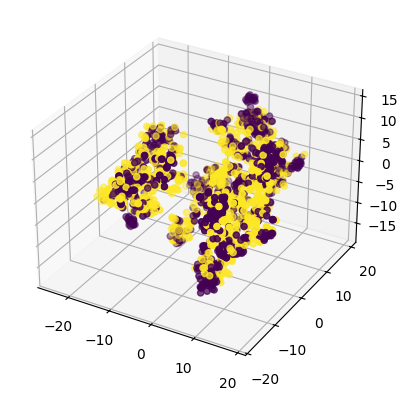

In [48]:
# color the data points by the label
# the first 1000 are aligned, the last 1000 are not_aligned
labels = np.concatenate((np.zeros(1000), np.ones(1000)), axis=0)
# draw the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2], c=labels)
plt.show()

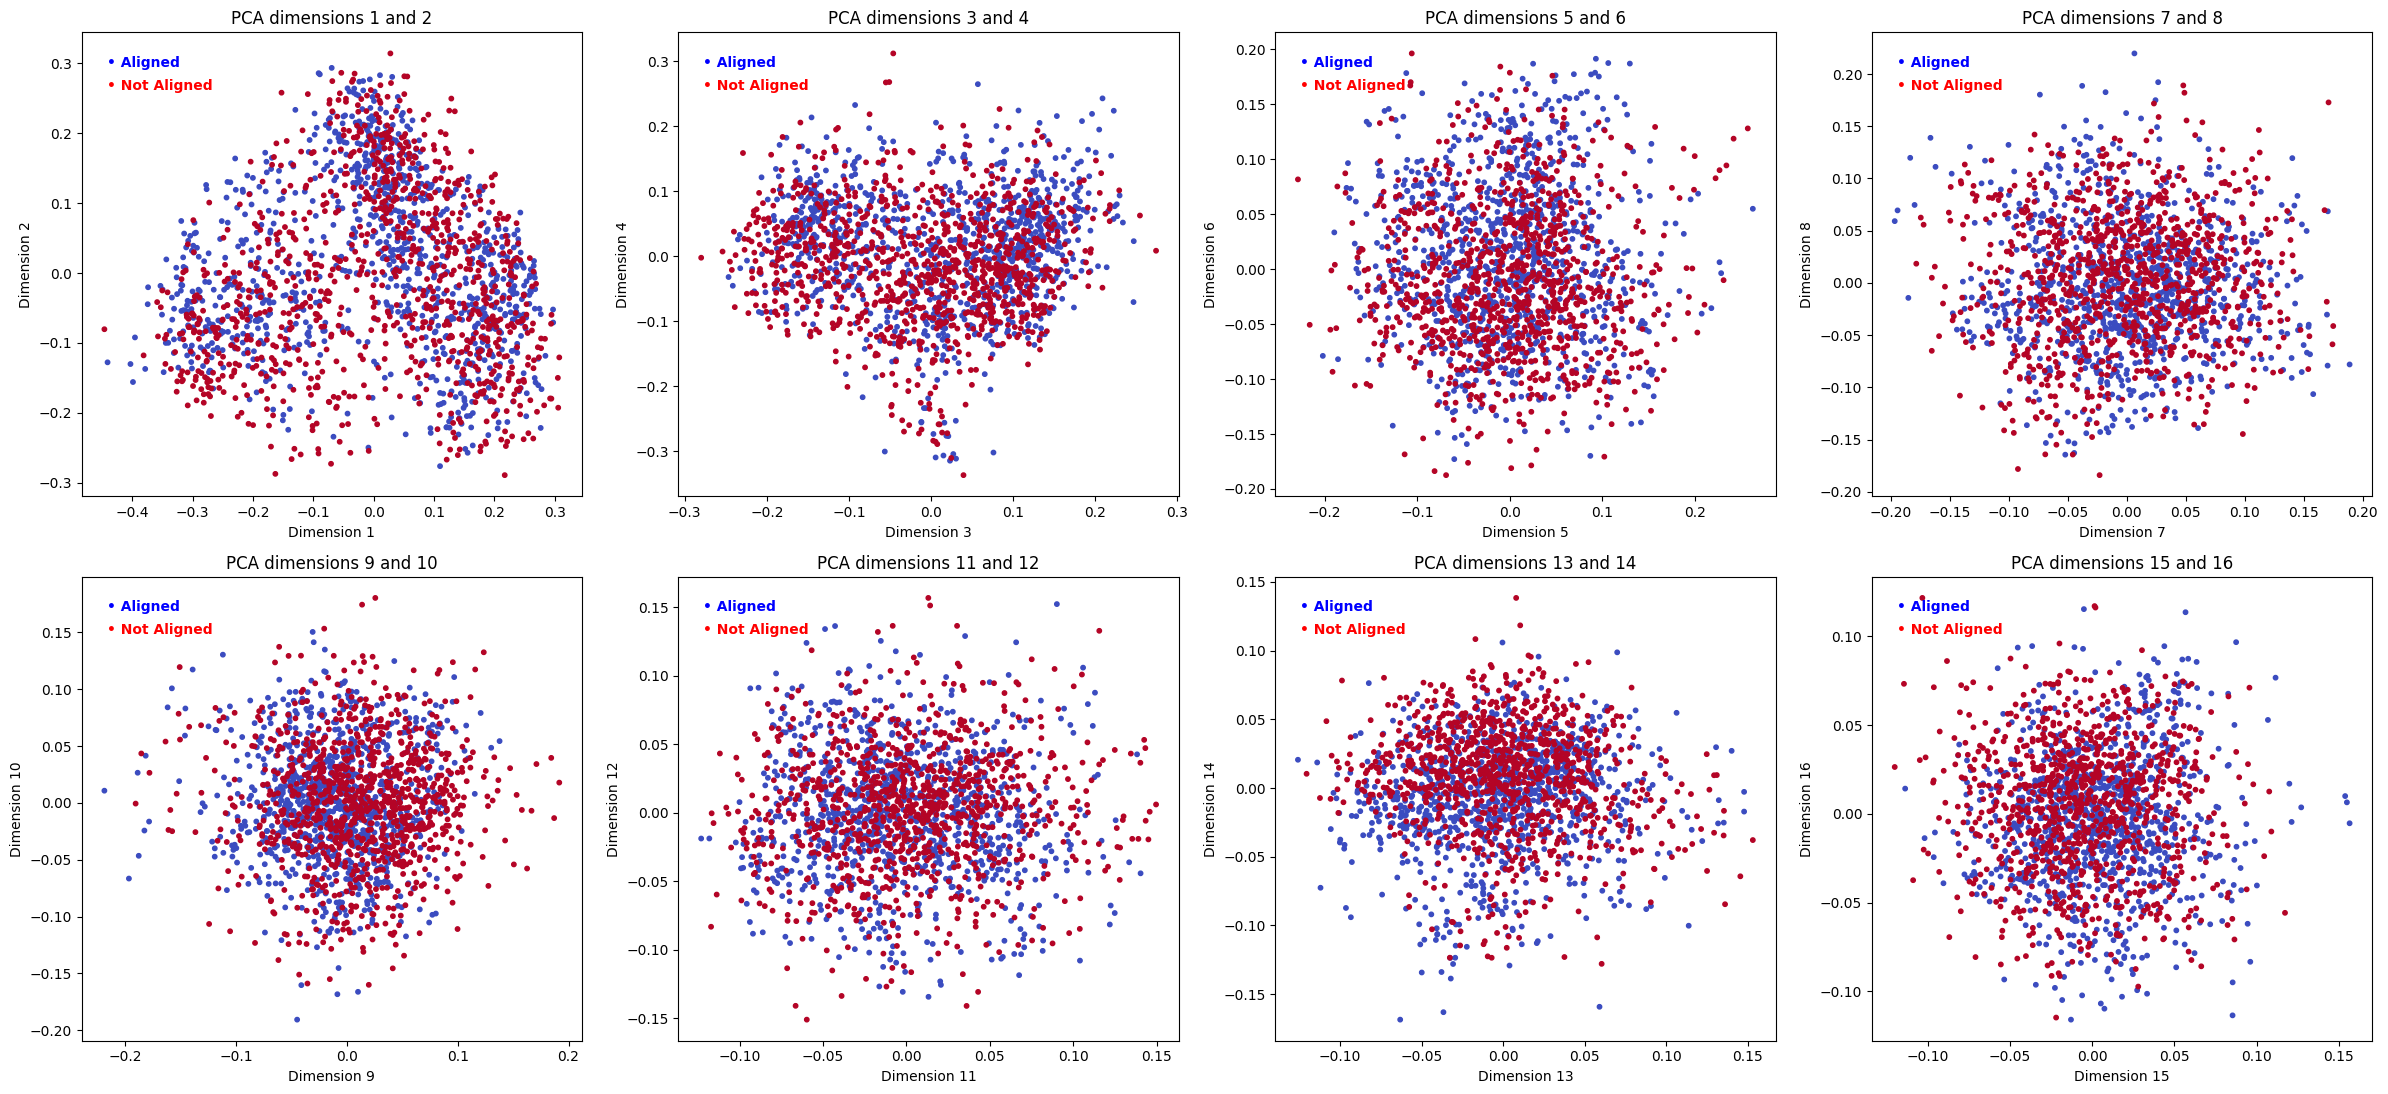

8 scatter plots have been created in a 2x4 grid with labels.


In [53]:
# 2. Draw multiple 2D scatter plots using the best dimensions
# Perform PCA to find the best dimensions
pca = PCA()
pca_result = pca.fit_transform(embeddings)

# Plot the top 8 dimension pairs in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for i in range(8):
    row = i // 4
    col = i % 4
    dim1 = i * 2
    dim2 = i * 2 + 1
    
    scatter = axs[row, col].scatter(pca_result[:, dim1], pca_result[:, dim2], c=labels, cmap='coolwarm', s=10)
    axs[row, col].set_title(f'PCA dimensions {dim1+1} and {dim2+1}')
    axs[row, col].set_xlabel(f'Dimension {dim1+1}')
    axs[row, col].set_ylabel(f'Dimension {dim2+1}')
    
    # Add labels for each class
    axs[row, col].text(0.05, 0.95, '• Aligned', transform=axs[row, col].transAxes, 
                       color='blue', fontweight='bold', va='top')
    axs[row, col].text(0.05, 0.90, '• Not Aligned', transform=axs[row, col].transAxes, 
                       color='red', fontweight='bold', va='top')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("8 scatter plots have been created in a 2x4 grid with labels.")